In [ ]:
!pip install torch-geometric
!pip install pyg-lib -f https://data.pyg.org/whl/torch-2.0.0+cu118.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 27.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=dca0ad263833f613483eab9c08d5c58de39d3edc4fa1727be8d233e0fd04d1cb
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 35.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import SAGEConv
from torch_geometric.datasets import CitationFull
from torch_geometric.data import DataLoader
from sklearn.metrics import f1_score,precision_score, recall_score
import torch.nn.functional as F
from torch.nn import Linear
import matplotlib.pyplot as plt
from torch_geometric.loader import NeighborLoader
from torch_geometric.datasets import Reddit

In [ ]:
dataset = Reddit(root='.')

Extracting ./raw/reddit.zip
Processing...
Done!


In [ ]:
data=dataset[0]

In [ ]:
data

Data(x=[232965, 602], edge_index=[2, 114615892], y=[232965], train_mask=[232965], val_mask=[232965], test_mask=[232965])

In [ ]:
data.train_mask

tensor([False,  True, False,  ...,  True,  True, False])

In [ ]:
data.val_mask

tensor([False, False, False,  ..., False, False, False])

In [ ]:
data.test_mask

tensor([ True, False,  True,  ..., False, False,  True])

In [ ]:
data.y

tensor([30, 17, 18,  ...,  3, 13, 13])

In [ ]:
data.x.shape

torch.Size([232965, 602])

In [ ]:
# !wget http://snap.stanford.edu/graphsage/reddit.zip

In [ ]:
# !unzip reddit.zip

In [ ]:
# import json
# with open('reddit/reddit-class_map.json','r') as f:
#   class_map = json.load(f)

In [ ]:
# import numpy as np
# set(class_map.values())

In [ ]:
nonzero,=torch.where(data.train_mask)
nonzero.shape

torch.Size([153431])

In [ ]:
nonzero_val,=torch.where(data.val_mask)
nonzero_val.shape

torch.Size([23831])

In [ ]:
nonzero_test,=torch.where(data.test_mask)
nonzero_test.shape

torch.Size([55703])

In [ ]:
len_train,len_val,len_test=[len(k) for k in [nonzero,nonzero_val,nonzero_test]]
total=len_train+len_val+len_test
print(total)
print([f'{k/total*100:.2f}' for k in [len_train,len_val,len_test]])

232965
['65.86', '10.23', '23.91']


In [ ]:
train_nbr_loader = NeighborLoader(data, [25,10], input_nodes=data.train_mask, batch_size=1024,shuffle=True)
val_nbr_loader = NeighborLoader(data, [25,10], input_nodes=data.val_mask, batch_size=1024)

In [ ]:
class GraphSAGE(torch.nn.Module):
  """GraphSAGE"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.sage1 = SAGEConv(dim_in, dim_h)
    #self.sageh1 = SAGEConv(dim_h, dim_h)
    #self.sageh2 = SAGEConv(dim_h, dim_h)
    #self.sageh3 = SAGEConv(dim_h, dim_h)
    self.sage2 = SAGEConv(dim_h, dim_out)

  def forward(self, x, edge_index):
    h = self.sage1(x, edge_index)
    h = torch.relu(h)
    #h = self.sageh1(h, edge_index)
    #h = h+torch.relu(h)
     #h = F.dropout(h, p=0.5, training=self.training)
    h = self.sage2(h, edge_index)
    return h

In [ ]:
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score

def train(model, epochs, loss, optimizer, train_loader, val_loader, device):
    tl = []
    vl = []
    f1s = []
    f1v = []
    total_train_loss = 0
    total_val_loss = 0
    total_train_f1 = 0
    total_val_f1 = 0

    for epoch in tqdm(range(epochs), desc='Epochs', unit='epochs', ncols=100):
        model.train()
        total_train_loss = 0
        total_val_loss = 0
        total_train_f1 = 0
        total_val_f1 = 0

        for sample_data in train_loader:
            sample_data = sample_data.to(device)

            out = model(sample_data.x, sample_data.edge_index)
            yhat = torch.argmax(out, dim=-1).detach().cpu().numpy()

            f1 = f1_score(sample_data.y.detach().cpu().numpy(), yhat, average='micro')
            total_train_f1 += f1

            total_loss = loss(out, sample_data.y)
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            total_train_loss += total_loss.item()

        tl.append(total_train_loss / len(train_loader))
        f1s.append(total_train_f1 / len(train_loader))

        with torch.no_grad():
            model.eval()

            for sample_data in val_loader:
                sample_data = sample_data.to(device)

                out = model(sample_data.x, sample_data.edge_index)
                y_hat = torch.argmax(out, dim=-1).detach().cpu().numpy()

                f1 = f1_score(sample_data.y.detach().cpu().numpy(), y_hat, average='micro')
                total_val_f1 += f1

                val_loss = loss(out, sample_data.y)
                total_val_loss += val_loss.item()

            vl.append(total_val_loss / len(val_loader))
            f1v.append(total_val_f1 / len(val_loader))

    # Calculate total F1 score, precision, and recall
    #total_f1 = sum(f1v) + sum(f1s)
    total_f1=f1_score(sample_data.y.detach().cpu().numpy(),y_hat,average='micro')
    total_precision = precision_score(sample_data.y.detach().cpu().numpy(), y_hat, average='micro')
    total_recall = recall_score(sample_data.y.detach().cpu().numpy(), y_hat, average='micro')

    print("Total F1 Score: ", total_f1)
    print("Total Precision: ", total_precision)
    print("Total Recall: ", total_recall)

    fig, ax = plt.subplots()
    ax.plot(range(epochs), tl, label='train_loss')
    ax.plot(range(epochs), vl, label='val_loss')
    # ax[1].plot(range(epochs), f1s, label='train_f1')
    #ax[1].plot(range(epochs), f1v, label='val_f1')
    ax.legend()

    plt.show()


In [ ]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
model=GraphSAGE(602,256,41).to(device)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.01, weight_decay=5e-4)

Epochs: 100%|███████████████████████████████████████████████████| 20/20 [23:51<00:00, 71.58s/epochs]


Total F1 Score:  0.9484657915840121
Total Precision:  0.9484657915840121
Total Recall:  0.9484657915840121


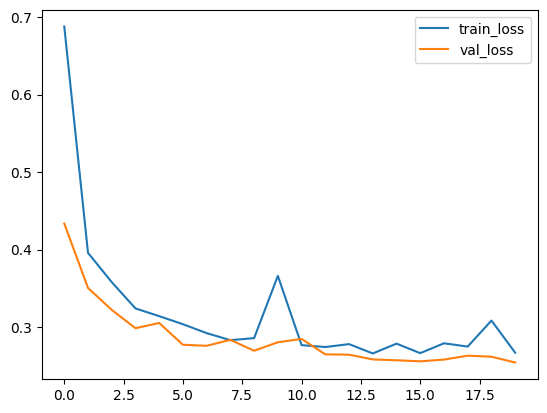

In [ ]:
train(model,20,loss_fn, optimizer,train_nbr_loader,val_loader=val_nbr_loader,device=device)